This notebook requires the BioSCRAPE package (https://github.com/biocircuits/bioscrape). BioSCRAPE can be installed from source or with pip (`pip install bioscrape`).

In [ ]:
!pip install bioscrape

In [1]:
import csv
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import copy
import os
from datetime import datetime
import random
import inspect
import pickle

import bioscrape as bs
import bioscrape.lineage as bs_lineage

%matplotlib inline
#%config InlineBackend.figure_f.ormats=['svg']
color_list = ['r', 'k', 'b','g','y','m','c']
mpl.rc('axes', prop_cycle=(mpl.cycler('color', color_list) ))
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

good_colors = {
    3: ["#1b9e77", "#d95f02","#7570b3"],
    5: ['#e41a1c', '#377eb8', '#4daf4a', 
        '#984ea3', '#ff7f00']
    }

# Utility funcs

We need a somewhat sophisticated growth model to implement selection for five plasmids in parallel (for lineage simulations). A cell can grow (or not die, depending on the selection type) if and only if it has at least one of each of its plasmids, each of which could be in one of a number of binding states. 

In [2]:
def make_growth_model(rxns, species, params, initial_conditions, selection = False,
                      selection_type = None):
    '''
    Adds some scaffolding to a model to put it in an exponentially-growing cell 
    with growth rate params['k_gamma']. Parameters are of the same type and 
    specification as used by bioscrape.types.Model.
    '''
    m = bs_lineage.LineageModel(reactions = rxns, 
                                parameters = params,
                                species = species,
                                initial_condition_dict = initial_conditions)

    # Multiplicative growth with rate set by k_gamma, but don't grow if any DNA 
    # species isn't present. 
    # NOTE: Assumes all DNA species have "DNA" in their names, and that DNA species names
    # contain underscores if and only if that species is bound to something.
    if selection and (selection_type is None or selection_type == "stop"):
        vol_rule_str = "volume * k_gamma * Heaviside("
        base_dna_species = [s for s in species if "DNA" in s and "_" not in s]
        grouped_dna_species = [[s for s in species if dna in s] for dna in base_dna_species]
        heaviside_strings = [" + ".join(group) for group in grouped_dna_species]
        vol_rule_str += " - 1) * Heaviside(".join(heaviside_strings)
        vol_rule_str += " - 1)"
    elif selection and selection_type == "die":
        vol_rule_str = "volume * k_gamma"
        base_dna_species = [s for s in species if "DNA" in s and "_" not in s]
        grouped_dna_species = [[s for s in species if dna in s] for dna in base_dna_species]
        heaviside_strings = [" + ".join(group) for group in grouped_dna_species]
        death_rule_str = "-1 * (Heaviside("
        death_rule_str += " - 1) * Heaviside(".join(heaviside_strings)
        death_rule_str += " - 1) - 1)"
        m.create_death_rule("general", {"equation": death_rule_str})
    else:
        vol_rule_str = "volume * k_gamma"
    m.create_volume_rule("ode", {"equation": vol_rule_str})

    # Divide when volume doubles (to 2), splitting all species binomially, with a small amount
    # of noise in volume partitioning.
    vsplit = bs_lineage.LineageVolumeSplitter(m, 
              options = {"default": "binomial"},
              partition_noise = 0.05)
    division_vol = 2
    m.create_division_rule("volume", {"threshold":division_vol}, vsplit)

    m.py_initialize()
    return m

In [3]:
def simulate_with_caching(cache_filename, **turbidostat_args):
    '''Wraps simulate_turbidostat_models, but memoizes the results in a file 
    cached_results/<cache_filename>. If that cache file exists, then the model in it 
    will be used instead of running the simulation again. Delete the cache file to
    run the simulation fresh. 
    '''
    if cache_filename is not None:
        full_cache_filename = os.path.join('cached_results', cache_filename)
    if cache_filename is not None and os.path.isfile(full_cache_filename):
        print(f"Using cached results from file {full_cache_filename}.")
        results = pickle.load(open(full_cache_filename, 'rb'))
    else:
        results = bs_lineage.py_SimulateTurbidostat(return_dataframes = False, 
                                                    return_sample_times = False,
                                                    **turbidostat_args)  
        if cache_filename is not None:
            pickle.dump(results, open(full_cache_filename, 'wb'))
    return results

# The CRISPRlator 

The CRISPRlator is a repressilator-like oscillator made using CRISPRi repressors. Each repressor consists of a guide RNA (gRNA) that binds to free dCas9; a dCas9:gRNA complex can bind to (and repress) a specific promoter targeted by that gRNA. An odd number of these gRNAs targeted to each other in a ring will, with the right parameters, oscillate. 

<img src="resources/CRISPRlator_diagram.png" alt="Drawing" style="height: 300px;"/>

We will show how how to simulate a CRISPRlator, first deterministically, then stochastically, and then stochastically with DNA that uses dummy-triggered replication.

# Deterministic:

In [4]:
# All parameters in units of 1/sec or 1/nM/sec
cas_params = dict()
cas_params['k_gamma']    = math.log(2) / (30 * 60)
cas_params['k_gRNA_prod_rate']   = 5.0 / 60 
cas_params['k_gRNA_deg_rate']    = math.log(2) / 100.0
cas_params['k_dCas_prod_rate']   = 4.5 * 1.0 / 60 # 4.5x other simulations
cas_params['k_dCas_deg_rate']    = 0 * cas_params['k_gamma']
cas_params['k_gRNA_bind']      = math.log(2) / 375.0
cas_params['k_gRNA_unbind']    = 0
cas_params['k_complex_bind']   = math.log(2) / 60.0
cas_params['k_complex_unbind'] = 0 #params['k_complex_bind'] / 1000.0 #<-- Just a guess!
cas_params['k_gRNA_leak_rate']   = 0# params['gRNA_prod_rate'] / 100.0

In [5]:
def make_CRISPRlator_model(params, initial_conditions, lineage = False, **kwargs):
    '''
    Uses a constant, non-replicating target plasmid that isn't diluted. 
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas_g{i}", f"DNA{prev_i}_g{i}"]
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas_g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}_g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        # Note that this is *in addition* to dilution.
        rxns.append(([f"DNA{prev_i}_g{i}"], [f"dCas_g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, 6):
            prev_i = (i-2)%5 + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}_g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions, **kwargs)
        return m

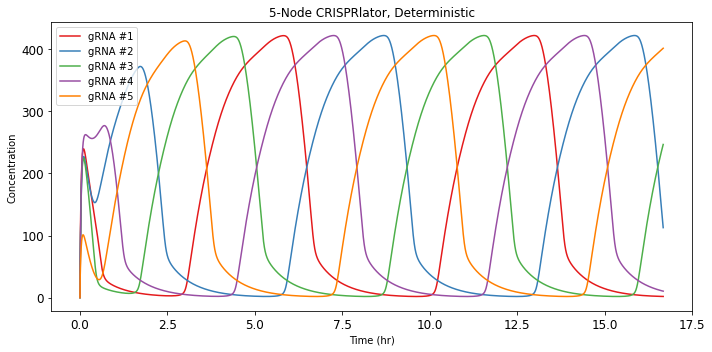

In [6]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}
simple_CRISPRlator_m = make_CRISPRlator_model(cas_params, initial_conditions, lineage = False)
ts = np.linspace(0, 60000, 10000)
simple_CRISPR_results = bs.simulator.py_simulate_model(ts, Model = simple_CRISPRlator_m, stochastic = False)

color_list = good_colors[5]
plt.figure(figsize = (10,5))
for i in range(5):
    j = i+1
    prev_i = (j-2)%5 + 1
    gRNA_concs = simple_CRISPR_results[f"g{j}"] + simple_CRISPR_results[f"dCas_g{j}"] + simple_CRISPR_results[f"DNA{prev_i}_g{j}"]
    plt.plot(ts/3600, gRNA_concs, color = color_list[i], label = f"gRNA #{j}")

plt.xlabel("Time (hr)")
plt.ylabel("Concentration")
plt.title("5-Node CRISPRlator, Deterministic")
plt.legend()
plt.tight_layout()
plt.show()


# Stochastic

Here's a simple version of a stochastic simulation in which plasmids are neither explicitly removed or produced. This means we will *not* see stochastic fluctuation of total plasmid copy number -- only of bound and unbound state copy numbers. 

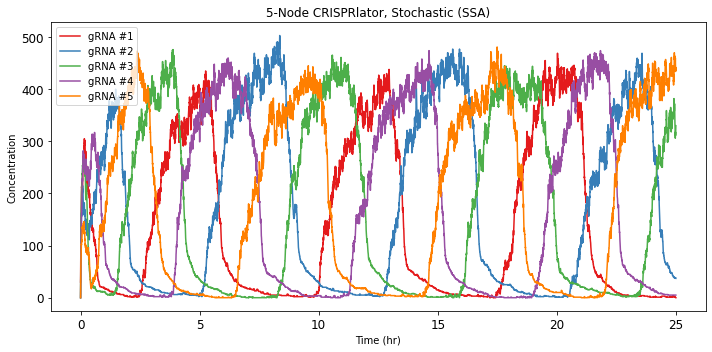

In [7]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}
ts = np.linspace(0, 90000, 10000)
simple_stoch_results = bs.simulator.py_simulate_model(ts, Model = simple_CRISPRlator_m, stochastic = True)

color_list = good_colors[5]
plt.figure(figsize = (10,5))
for i in range(5):
    j = i+1
    prev_i = (j-2)%5 + 1
    gRNA_concs = simple_stoch_results[f"g{j}"] + simple_stoch_results[f"dCas_g{j}"] + simple_stoch_results[f"DNA{prev_i}_g{j}"]
    plt.plot(ts/3600, gRNA_concs, color = color_list[i], label = f"gRNA #{j}")

plt.xlabel("Time (hr)")
plt.ylabel("Concentration")
plt.legend()
plt.title("5-Node CRISPRlator, Stochastic (SSA)")
plt.tight_layout()
plt.show()


# Lineages

Now we switch to lineage simulations of the CRISPRlator, which can't implicitly assume constant plasmid concentration. Accordingly, we'll have to add plasmid replication. Examples are shown for trivial replication, dummy-triggered replication, Brendel & Perelson's ColE1 model, and the simplified three-species ColE1 model.

Note that some of these simulations can take a long time to run. Accordingly, we've cached simulation results run with the `simulate_with_caching` function in files in the `cached_results` folder. If you want to run any simulation fresh, you can either delete the cached result file (in which case your newly-run result will become the new cached result) or change the first argument of `simulate_with_caching` to `None`.

### Trivial model (bad)

In [8]:
def make_CRISPRlator_trivial(params, initial_conditions, lineage = False, **kwargs):
    '''
    Assumes abundant dCas, instant and perfect binding. Plasmids replicate the dumb way.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas:g{i}", f"DNA{prev_i}:g{i}"]
        
        # Plasmid replication (trivial)
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"DNA{i}"], 'massaction', {'k': params['k_gamma']}))
        rxns.append(([f"DNA{prev_i}_g{i}"], [f"DNA{prev_i}", f"DNA{prev_i}", f"dCas_{i}"], 'massaction', {'k': params['k_gamma']}))        
        
        # Everything else
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas_g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}_g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        #rxns.append(([f"DNA{prev_i}:g{i}"], [f"dCas:g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, 6):
            prev_i = (i-2)%5 + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}_g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions, **kwargs)
        return m

In [9]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

seed = 42335
np.random.seed(seed)
bs.random.py_seed_random(seed)

start_time = datetime.now()
# The trivial model spreads more over time, so worth simulating longer
# to get more distributional info.
n_generations = 30
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

trivial_model = make_CRISPRlator_trivial(cas_params, initial_conditions, lineage = True)    

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
trivial_results = simulate_with_caching('CRISPR_trivial.pkl',
                                        initial_cell_states = 1, 
                                        timepoints = temp_ts,
                                        sample_times = sample_times,
                                        population_cap = 1,
                                        Model = trivial_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

Using cached results from file cached_results/CRISPR_trivial.pkl.
execution time: 0:00:00.009890


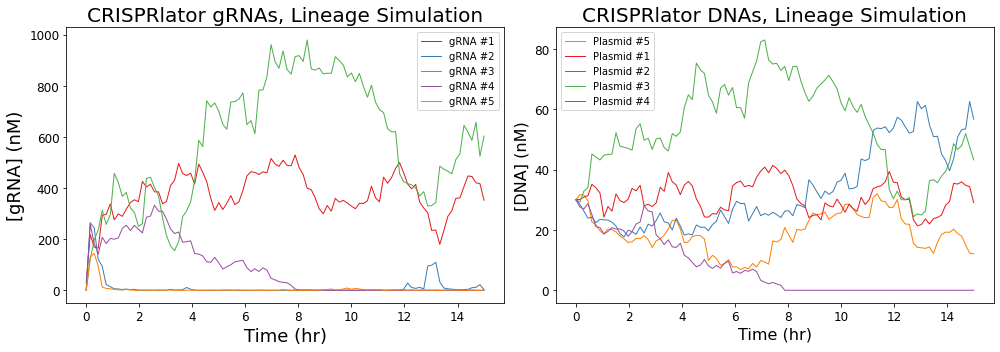

In [10]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in trivial_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

max_time = 26
plotting_ts = [t for t in plotting_ts if t < max_time]
#all_states = [cs for cs in all_states if cs.py_get_time()/3600 < max_time]

subplot1 = plt.subplot(121)
subplot2 = plt.subplot(122)
for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = trivial_model.get_species2index()[f"g{i}"]
    dCas_idx = trivial_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = trivial_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = trivial_model.get_species2index()[f"DNA{prev_i}"]

    
    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[i] + dCas_gRNA[i] + dna_gRNA[i] for i in range(len(all_states))]
    total_dna = [bare_dna[i] + dna_gRNA[i] for i in range(len(all_states))]

#     plt.subplot(121)
    max_time = 20
    subplot1.plot(plotting_ts, total_gRNA[:len(plotting_ts)], label = f"gRNA #{i}", 
                color = good_colors[5][i-1], lw = 1)
#     plt.subplot(122)
    subplot2.plot(plotting_ts, total_dna[:len(plotting_ts)], label = f"Plasmid #{prev_i}",
                color = good_colors[5][prev_i-1], lw = 1)
    
subplot1.set_xlabel("Time (hr)", fontsize = 18)
subplot1.set_ylabel("[gRNA] (nM)", fontsize = 18)
subplot1.set_title(f"CRISPRlator gRNAs, Lineage Simulation", fontsize = 20)
subplot1.legend()

subplot2.set_xlabel("Time (hr)", fontsize = 16)
subplot2.set_ylabel("[DNA] (nM)", fontsize = 16)
subplot2.set_title("CRISPRlator DNAs, Lineage Simulation", fontsize = 20)
subplot2.legend()
plt.tight_layout()
plt.savefig(os.path.join("results","trivial_CRISPRlator.pdf"))
plt.show()

### Dummy-Triggered Replication

In [11]:
def make_CRISPRlator_dummy(params, initial_conditions, lineage = False, n_nodes = 5, **kwargs):
    '''
    Assumes abundant dCas, instant and perfect binding. Plasmids replicate the dumb way.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, n_nodes + 1):
        prev_i = (i-2)%n_nodes + 1
        species += [f"g{i}", f"DNA{i}", f"dCas_g{i}", f"DNA{prev_i}_g{i}"]
        
        # Plasmid replication (dummy-triggered)
        rxns.append(([], [f"R{i}"], 'massaction', {'k': initial_conditions["DNA1"]*params['k_gamma']}))
        rxns.append(([f"DNA{i}", f"R{i}"], [f"DNA{i}", f"DNA{i}"], 'massaction', {'k': 10*params['k_gamma']}))
        rxns.append(([f"DNA{prev_i}_g{i}", f"R{prev_i}"], [f"DNA{prev_i}", f"DNA{prev_i}", f"dCas_g{i}"], 'massaction', {'k': 10*params['k_gamma']}))        
        
        # Everything else
        rxns.append(([f"DNA{i}"], [f"DNA{i}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"dCas_g{i}", f"DNA{prev_i}"], [f"DNA{prev_i}_g{i}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target
        #rxns.append(([f"DNA{prev_i}:g{i}"], [f"dCas:g{i}", f"DNA{prev_i}"], 'massaction', {'k': params["k_gamma"]})) # dCas complex unbinding from target
        
    if not lineage:
        rxns.append((["dCas"], [], 'massaction', {'k': params["k_gamma"]})) # dCas dilution
        for i in range(1, n_nodes + 1):
            prev_i = (i-2)%n_nodes + 1
            rxns.append(([f"g{i}"], [], 'massaction', {'k':params['k_gamma']})) # 
            rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_gamma']}))
            rxns.append(([f"DNA{prev_i}_g{i}"], [f"DNA{prev_i}"], 'massaction', {'k': params['k_gamma']}))
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions, **kwargs)
        return m

In [12]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

dummy_model = make_CRISPRlator_dummy(cas_params, initial_conditions, lineage = True)

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
dummy_results = simulate_with_caching('CRISPR_dummy.pkl',
                                      initial_cell_states = 1, 
                                      timepoints = temp_ts,
                                      sample_times = sample_times,
                                      population_cap = 1,
                                      Model = dummy_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

Using cached results from file cached_results/CRISPR_dummy.pkl.
execution time: 0:00:00.006961


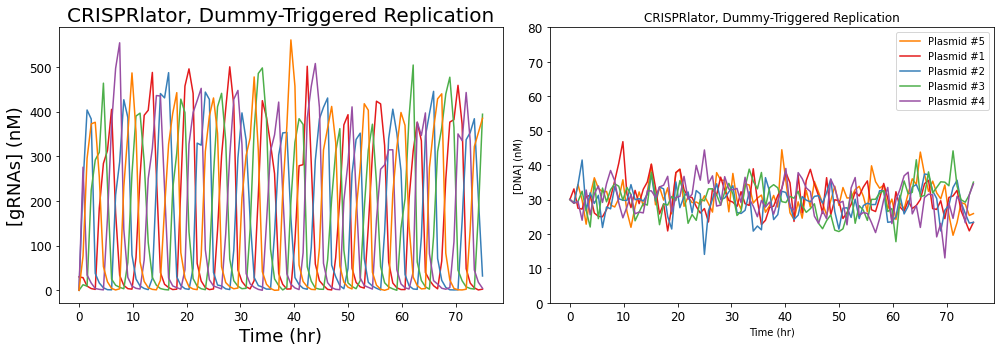

In [13]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in dummy_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = (i-2)%5 + 1
    gRNA_idx = dummy_model.get_species2index()[f"g{i}"]
    dCas_idx = dummy_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = dummy_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = dummy_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    
    
    plt.subplot(121)
    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = good_colors[5][i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = good_colors[5][prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)", fontsize = 18)
plt.ylabel("[gRNAs] (nM)", fontsize = 18)
plt.title(f"CRISPRlator, Dummy-Triggered Replication", fontsize = 20)
# plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.ylim(0,80)
plt.title("CRISPRlator, Dummy-Triggered Replication")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('results', 'dummy_results.pdf'))
plt.show()

And with three nodes:

In [14]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

dummy_3n_model = make_CRISPRlator_dummy(cas_params, initial_conditions, n_nodes = 3,
                                        lineage = True)

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
dummy_3n_results = simulate_with_caching('CRISPR_dummy_3n.pkl',
                                      initial_cell_states = 1, 
                                      timepoints = temp_ts,
                                      sample_times = sample_times,
                                      population_cap = 1,
                                      Model = dummy_3n_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

Using cached results from file cached_results/CRISPR_dummy_3n.pkl.
execution time: 0:00:00.016715


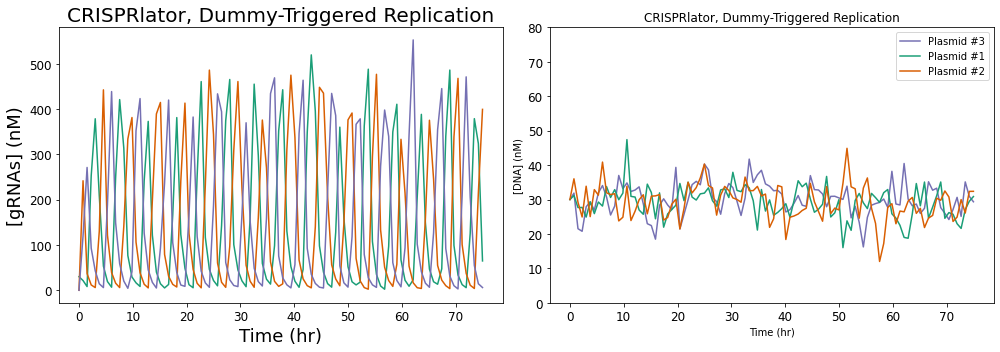

In [15]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in dummy_3n_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 4):
    prev_i = (i-2)%3 + 1
    gRNA_idx = dummy_3n_model.get_species2index()[f"g{i}"]
    dCas_idx = dummy_3n_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = dummy_3n_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = dummy_3n_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    
    
    plt.subplot(121)
    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = good_colors[3][i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = good_colors[3][prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)", fontsize = 18)
plt.ylabel("[gRNAs] (nM)", fontsize = 18)
plt.title(f"CRISPRlator, Dummy-Triggered Replication", fontsize = 20)
# plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.ylim(0,80)
plt.title("CRISPRlator, Dummy-Triggered Replication")
plt.legend()
plt.tight_layout()
plt.show()

### B&P

In [16]:
def make_CRISPRlator_bp(params, initial_conditions, lineage = False, **kwargs):
    '''
    Assumes abundant dCas, instant and perfect binding.
    
    Plasmids replicate with B&P-based ColE1 mechanism.
    '''
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{prev_i}", f"dCas_g{i}", f"DNA{prev_i}_g{i}", f"DNA{prev_i}_RI"]
        
        # Plasmid replication (B&P)
        for DNA in [f"DNA{prev_i}", f"DNA{prev_i}_g{i}"]:
            for dna_suffix in ["_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]:
                species.append(f"{DNA}{dna_suffix}")
            rxns.append(([f"{DNA}"], [f"{DNA}_RIIs"], "massaction", {"k": "k_II"}))
            rxns.append(([f"{DNA}"], [f"{DNA}", f"DNA{prev_i}_RI"], "massaction", {"k": "k_I"}))
            rxns.append(([f"{DNA}_RIIs"], [f"{DNA}_RIIL"], "massaction", {"k": "k_L"}))
            rxns.append(([f"{DNA}_RIIL"], [f"{DNA}"], "massaction", {"k": "k_mL"}))
            rxns.append(([f"{DNA}_RIIL"], [f"{DNA}_p"], "massaction", {"k": "k_p"}))
            # Replication strips off dCas
            rep_prods = [f"DNA{prev_i}"]*2
            if "_g" in DNA:# DNA == f"DNA{prev_i}:g{i}":
                rep_prods += [f"dCas_g{i}"]
            rxns.append(([f"{DNA}_p"], rep_prods, "massaction", {"k": "k_D"}))
            rxns.append(([f"{DNA}_RIIs", f"DNA{prev_i}_RI"], [f"{DNA}_II_Iu"], "massaction", {"k": "k_1"}))
            rxns.append(([f"{DNA}_II_Iu"], [f"{DNA}_RIIs", f"DNA{prev_i}_RI"], "massaction", {"k": "k_m1"}))
            rxns.append(([f"{DNA}_II_Iu"], [f"{DNA}_II_Is"], "massaction", {"k": "k_2"}))
            rxns.append(([f"{DNA}_II_Is"], [f"{DNA}_II_Iu"], "massaction", {"k": "k_m2"}))
            rxns.append(([f"{DNA}_II_Is"], [f"{DNA}"], "massaction", {"k": "k_mC"}))
        
        # Everything else
        rxns.append(([f"DNA{prev_i}_RI"], [], "massaction", {"k": "k_gamma_I"})) # Active RNA degradation
        for dna_suffix in ["", "_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]:
            DNA = f"DNA{prev_i}{dna_suffix}"
            rxns.append(([f"{DNA}"], [f"{DNA}", f"g{prev_i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
            rxns.append(([f"dCas_g{i}", f"DNA{prev_i}{dna_suffix}"], [f"DNA{prev_i}_g{i}{dna_suffix}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target            
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
    if not lineage:
        for s in species:
            rxns.append(([s], [], 'massaction', {'k': params["k_gamma"]})) # dilution
        
        return bs.types.Model(species = species, parameters = params, reactions = rxns,
                              initial_condition_dict = initial_conditions)
    else:
        m = make_growth_model(rxns, species, params, initial_conditions, **kwargs)
        return m

In [17]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

# DNA replication parameters taken from Brendel & Perelsen 1993 
# (https://doi.org/10.1006/jmbi.1993.1092) and converted to 
# /sec units.
bp_params = copy.copy(cas_params)
bp_params["k_II"] = 0.25 / 60
bp_params["k_L"] = 12.0 / 60
bp_params["k_mL"] = 4.3 / 60
bp_params["k_p"] = 4.3 / 60
bp_params["k_D"] = 5 / 60
bp_params["k_1"] = 0.15 / 60
bp_params["k_m1"] = 48 / 60
bp_params["k_2"] = 44 / 60
bp_params["k_m2"] = 0.085 / 60
bp_params["k_mC"] = 17 / 60
bp_params["k_I"] = 6 / 60
bp_params["k_gamma_I"] = .35 / 60
seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()

n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

bp_model = make_CRISPRlator_bp(bp_params, initial_conditions, lineage = True)   

det_bp_results = bs.simulator.py_simulate_model(temp_ts, 
                        Model = make_CRISPRlator_bp(bp_params, initial_conditions, lineage = False))

bp_results = simulate_with_caching('CRISPR_bp_colE1.pkl',
                                   initial_cell_states = 1, 
                                   timepoints = temp_ts,
                                   sample_times = sample_times,
                                   population_cap = 1,
                                   Model = bp_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

Using cached results from file cached_results/CRISPR_bp_colE1.pkl.
execution time: 0:00:02.377858


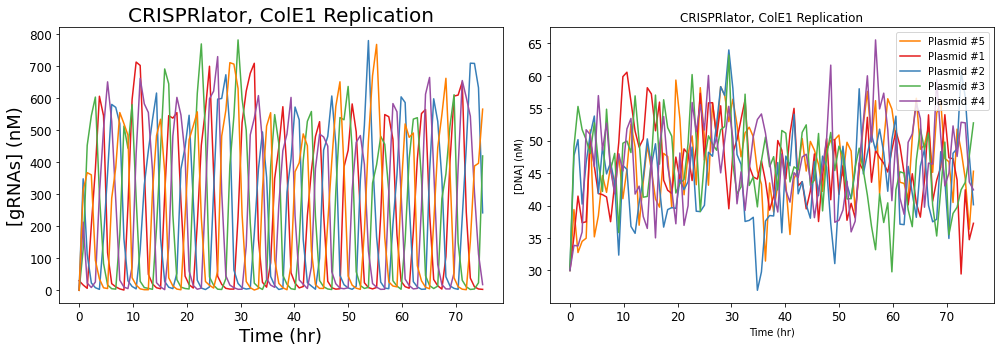

In [18]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in bp_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = (i-2)%5 + 1
    
#     total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
#     total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]
    
    dna_base_names = [f"DNA{prev_i}", f"DNA{prev_i}_g{i}"]
    dna_suffixes = ["", "_RIIs", "_RIIL", "_II_Is", "_II_Iu", "_p"]
    dna_species = []
    for base_name in dna_base_names:
        for suffix in dna_suffixes:
            dna_species.append(f"{base_name}{suffix}")
    gRNA_species = [f"g{i}", f"dCas_g{i}"]
    for suffix in dna_suffixes:
        gRNA_species.append(f"DNA{prev_i}_g{i}{suffix}")
    
    total_gRNA = [sum([cs.py_get_state()[bp_model.get_species2index()[s]]/cs.py_get_volume() for s in gRNA_species]) \
                  for cs in all_states]
    total_dna = [sum([cs.py_get_state()[bp_model.get_species2index()[s]]/cs.py_get_volume() for s in dna_species]) \
                  for cs in all_states]

    plt.subplot(121)
    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = good_colors[5][i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = good_colors[5][prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)", fontsize = 18)
plt.ylabel("[gRNAs] (nM)", fontsize = 18)
plt.title(f"CRISPRlator, ColE1 Replication", fontsize = 20)
# plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
# plt.ylim(0,80)
plt.title("CRISPRlator, ColE1 Replication")
plt.legend()
plt.tight_layout()
plt.show()

### Three-Species ColE1

In [19]:
def make_CRISPRlator_three_species(params, initial_conditions, lineage = False, **kwargs):
    '''
    Assumes abundant dCas, instant and perfect binding.
    
    Plasmids replicate with simplified ColE1 mechanism.
    '''
    if not lineage:
        raise ValueError("This should always be called as a lineage.")
    rxns = []
    species = ['dCas']
    rxns.append(([], ['dCas'], 'massaction', {'k': params["k_dCas_prod_rate"]})) # dCas prod rate
    rxns.append((['dCas'], [], 'massaction', {'k': params['k_dCas_deg_rate']}))  # dCas degradation
    for i in range(1, 6):
        prev_i = (i-2)%5 + 1
        species += [f"g{i}", f"DNA{i}", f"dCas_g{i}", f"DNA{prev_i}_g{i}"]
        
        # Plasmid replication (Simplified B&P)
        for DNA in [f"DNA{prev_i}", f"DNA{prev_i}_g{i}"]:
            rxns.append(([f"{DNA}"], [f"{DNA}_p"], 'massaction', {'k': 'k_p'}))
            rep_prods = [f"DNA{prev_i}", f"DNA{prev_i}"]
            if DNA == f"DNA{prev_i}_g{i}":
                rep_prods.append(f"dCas_g{i}")
            rxns.append(([f"{DNA}_p"], rep_prods, 'massaction', {'k': 'k_rep'}))
            rxns.append(([f"{DNA}"], [f"{DNA}", f"R{prev_i}"], 'massaction', {'k': 'k_tx'}))
            rxns.append(([f"{DNA}_p", f"R{prev_i}"], [f"{DNA}"], 'massaction', {'k': 'k_I'}))
        
        # Everything else
        for dna_suffix in ["", "_p"]:
            DNA = f"DNA{prev_i}{dna_suffix}"
            species.append(DNA)
            rxns.append(([f"DNA{i}{dna_suffix}"], [f"DNA{i}{dna_suffix}", f"g{i}"], 'massaction', {'k': params['k_gRNA_prod_rate']})) # gRNA production
            rxns.append(([f"dCas_g{i}", f"{DNA}"], [f"DNA{prev_i}_g{i}{dna_suffix}"], 'massaction', {'k': params["k_complex_bind"]})) # dCas complex binding to target            
        rxns.append(([f"g{i}"], [], 'massaction', {'k': params["k_gRNA_deg_rate"]})) # gRNA Degradation
        rxns.append(([f"g{i}", "dCas"], [f"dCas_g{i}"], 'massaction', {'k': params["k_gRNA_bind"]})) # gRNA binding to dCas
        rxns.append(([f"dCas_g{i}"], ["dCas", f"g{i}"], 'massaction', {'k': params["k_gRNA_unbind"]})) # gRNA unbinding from dCas
        rxns.append(([f"dCas_g{i}"], [], 'massaction', {'k': params['k_dCas_deg_rate']})) # dCas:gRNA degradation
        rxns.append(([f"R{prev_i}"], [], 'massaction', {'k': 'k_gamma_I'})) # regulatory RNA degradation
    m = make_growth_model(rxns, species, params, initial_conditions, **kwargs)
    return m

In [20]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "DNA4": 30,
    "DNA5": 30,
    "dCas": 43,
    "g1": 30
}

# Parameters are taken from the fit in section 2.4 of summary_table_plots.ipynb,
# rescaled to dilution rate.
three_species_params = copy.copy(cas_params)
three_species_params["k_rep"]     = three_species_params['k_gamma'] * 16.126457
three_species_params["k_tx"]      = three_species_params['k_gamma'] * 275.329941
three_species_params["k_I"]       = three_species_params['k_gamma'] * 0.695778
three_species_params["k_p"]       = three_species_params['k_gamma'] * 33.330187
three_species_params["k_gamma_I"] = three_species_params['k_gamma'] * 14.327573

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()

n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)#n_generations*100)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

three_species_model = make_CRISPRlator_three_species(three_species_params, 
                                                     initial_conditions, 
                                                     lineage = True)    

three_species_results = simulate_with_caching('CRISPR_3s.pkl',
                                              initial_cell_states = 1, 
                                              timepoints = temp_ts,
                                              sample_times = sample_times,
                                              population_cap = 1,
                                              Model = three_species_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

Using cached results from file cached_results/CRISPR_3s.pkl.
execution time: 0:00:00.010643


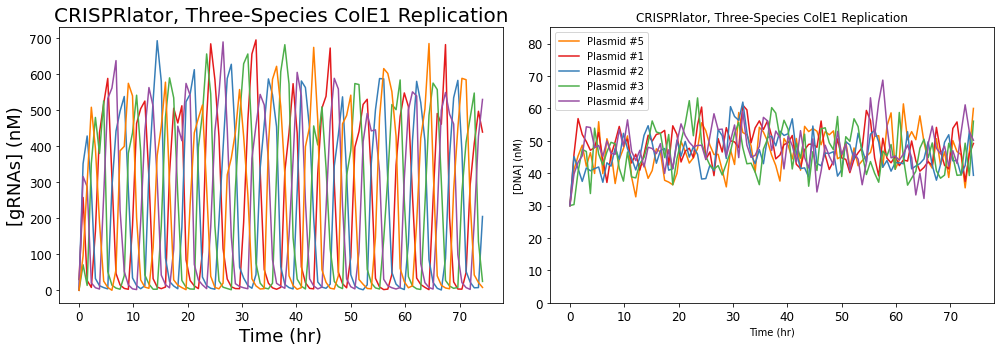

In [21]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in three_species_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    
    dna_base_names = [f"DNA{prev_i}", f"DNA{prev_i}_g{i}"]
    dna_suffixes = ["", "_p"]
    dna_species = []
    for base_name in dna_base_names:
        for suffix in dna_suffixes:
            dna_species.append(f"{base_name}{suffix}")
    gRNA_species = [f"g{i}"]
    for suffix in dna_suffixes:
        gRNA_species.append(f"DNA{prev_i}_g{i}{suffix}")
    
    total_gRNA = [sum([cs.py_get_state()[three_species_model.get_species2index()[s]]/cs.py_get_volume() for s in gRNA_species]) \
                  for cs in all_states]
    total_dna = [sum([cs.py_get_state()[three_species_model.get_species2index()[s]]/cs.py_get_volume() for s in dna_species]) \
                  for cs in all_states]

    plt.subplot(121)
    min_t = 0
    plt.plot(plotting_ts[min_t:-1], total_gRNA[min_t:-1], label = f"gRNA #{i}", 
                color = good_colors[5][i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts[min_t:-1], total_dna[min_t:-1], label = f"Plasmid #{prev_i}",
                color = good_colors[5][prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)", fontsize = 18)
plt.ylabel("[gRNAs] (nM)", fontsize = 18)
plt.title(f"CRISPRlator, Three-Species ColE1 Replication", fontsize = 20)
# plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.ylim(0, 85)
plt.title("CRISPRlator, Three-Species ColE1 Replication")
plt.legend()
plt.tight_layout()
plt.show()

# Comparison to empirical experimental data

Two papers have now built real-world three-node CRISPRlators:
* Kuo, Yuan, Sanchez, Paulsson, and Silver's "Toward a translationally independent RNA-based synthetic oscillator using deactivated CRISPR-Cas" (https://doi.org/10.1093/nar/gkaa557)
* Santos-Moreno, Tasiudi, Stelling, and Schaerli's "Multistable and dynamic CRISPRi-based synthetic circuits" (https://doi.org/10.1038/s41467-020-16574-1).

Let's try to replicate their results, more or less.

In [22]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

dummy_model_3n = make_CRISPRlator_dummy(cas_params, initial_conditions, n_nodes = 3, lineage = True)

dummy_results_3n = simulate_with_caching('comparison_data.pkl',
                                      initial_cell_states = 1, 
                                      timepoints = temp_ts,
                                      sample_times = sample_times,
                                      population_cap = 1,
                                      Model = dummy_model_3n, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

Using cached results from file cached_results/comparison_data.pkl.
execution time: 0:00:00.009992


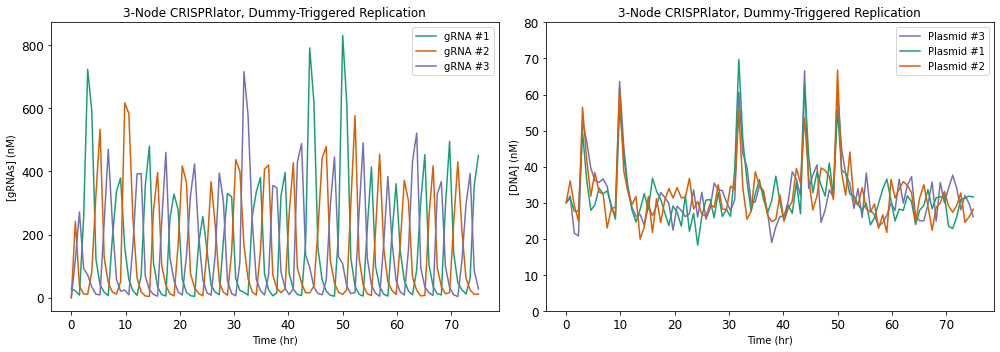

In [23]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in dummy_results_3n for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 4):
    prev_i = (i-2)%3 + 1
    gRNA_idx = dummy_model_3n.get_species2index()[f"g{i}"]
    dCas_idx = dummy_model_3n.get_species2index()[f"dCas_g{i}"]
    dna_idx = dummy_model_3n.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = dummy_model_3n.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]
    
    plt.subplot(121)
    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = good_colors[3][i-1])#, s = 9)
    plt.subplot(122)
    plt.plot(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = good_colors[3][prev_i-1])#, s = 9)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"3-Node CRISPRlator, Dummy-Triggered Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.ylim(0,80)
plt.title("3-Node CRISPRlator, Dummy-Triggered Replication")
plt.legend()
plt.tight_layout()
plt.show()

Same data, drawn more comparably to the data from Paulsson's paper (same time scale and units, only one color):

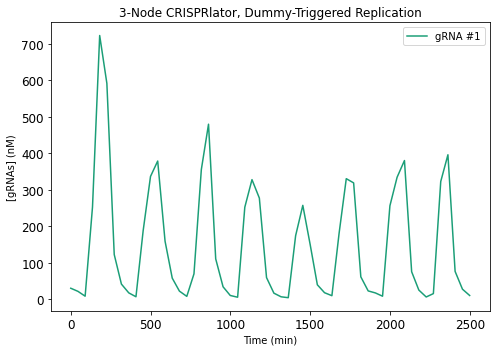

In [24]:
def draw_paulsson_data(results, model):
    plt.figure(figsize = (7,5))

    all_states = [cs for state_list in results for cs in state_list if cs.py_get_time()/60 < 2500]
    plotting_ts = [cs.py_get_time()/60 for cs in all_states]

    i = 1
    prev_i = 3
    gRNA_idx = model.get_species2index()[f"g{i}"]
    dCas_idx = model.get_species2index()[f"dCas_g{i}"]
    dna_idx = model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = good_colors[3][i-1])#, s = 9)

    plt.xlabel("Time (min)")
    plt.ylabel("[gRNAs] (nM)")
    plt.title(f"3-Node CRISPRlator, Dummy-Triggered Replication")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
draw_paulsson_data(dummy_results_3n, dummy_model_3n)

And shown comparably to Schaerli's paper:

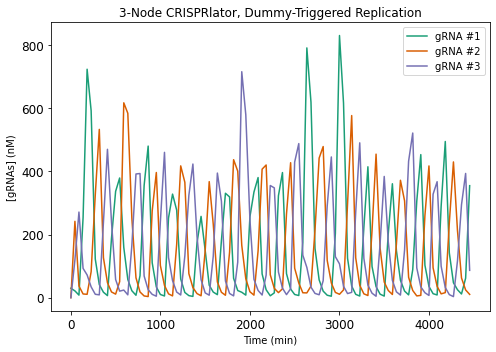

In [25]:
def draw_schaerli_data(results, model):
    plt.figure(figsize = (7,5))

    all_states = [cs for state_list in results for cs in state_list if cs.py_get_time()/60 < 4500]
    plotting_ts = [cs.py_get_time()/60 for cs in all_states]

    for i in range(1, 4):
        prev_i = (i-2)%3 + 1
        gRNA_idx = model.get_species2index()[f"g{i}"]
        dCas_idx = model.get_species2index()[f"dCas_g{i}"]
        dna_idx = model.get_species2index()[f"DNA{prev_i}_g{i}"]
        bare_dna_idx = model.get_species2index()[f"DNA{prev_i}"]

        bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
        dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
        dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
        bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
        total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
        total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

        plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                    color = good_colors[3][i-1])#, s = 9)

    plt.xlabel("Time (min)")
    plt.ylabel("[gRNAs] (nM)")
    plt.title(f"3-Node CRISPRlator, Dummy-Triggered Replication")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
draw_schaerli_data(dummy_results_3n, dummy_model_3n)

Some differences:
* Paulsson's data looks a lot messier than this, and their oscillations are faster. 
* In contrast, Schaerli's results show much, much slower oscillations.

Let's try to match the Paulsson data first. One thing we can note is that Paulsson's circuits are all on lower copy number -- either pSC101 (copy number ~5) or genomic. Let's try scaling down copy number, with dCas production scaled appropriately. 

execution time: 0:00:00.224193


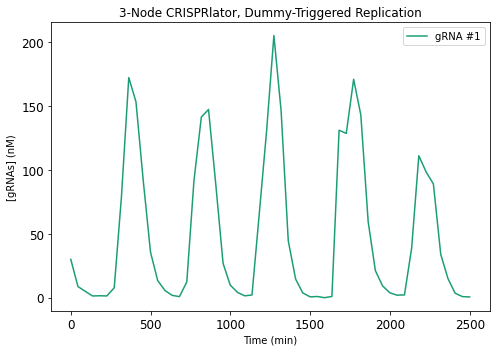

In [26]:
initial_conditions = {
    "DNA1": 5,
    "DNA2": 5,
    "DNA3": 5,
    "dCas": 43,
    "g1": 30
}

temp_params = copy.deepcopy(cas_params)
temp_params['k_dCas_prod_rate'] /= 2

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.
    
paulsson_3n_model = make_CRISPRlator_dummy(temp_params, initial_conditions, n_nodes = 3, lineage = True)

paulsson_3n_results = simulate_with_caching(None,
                                      initial_cell_states = 1, 
                                      timepoints = temp_ts,
                                      sample_times = sample_times,
                                      population_cap = 1,
                                      Model = paulsson_3n_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

draw_paulsson_data(paulsson_3n_results, paulsson_3n_model)

This is still a bit slow, and still too neat. However, this is with ideally-tuned dCas production. We can get realistically-messier results by un-tuning dCas production rate:

Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
execution time: 0:00:01.533887
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
execution time: 0:00:01.625115
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
execution time: 0:00:01.563427
execution time: 0:00:00.291814
execution time: 0:00:00.173356
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, repeating simultion
Lost a plasmid, r

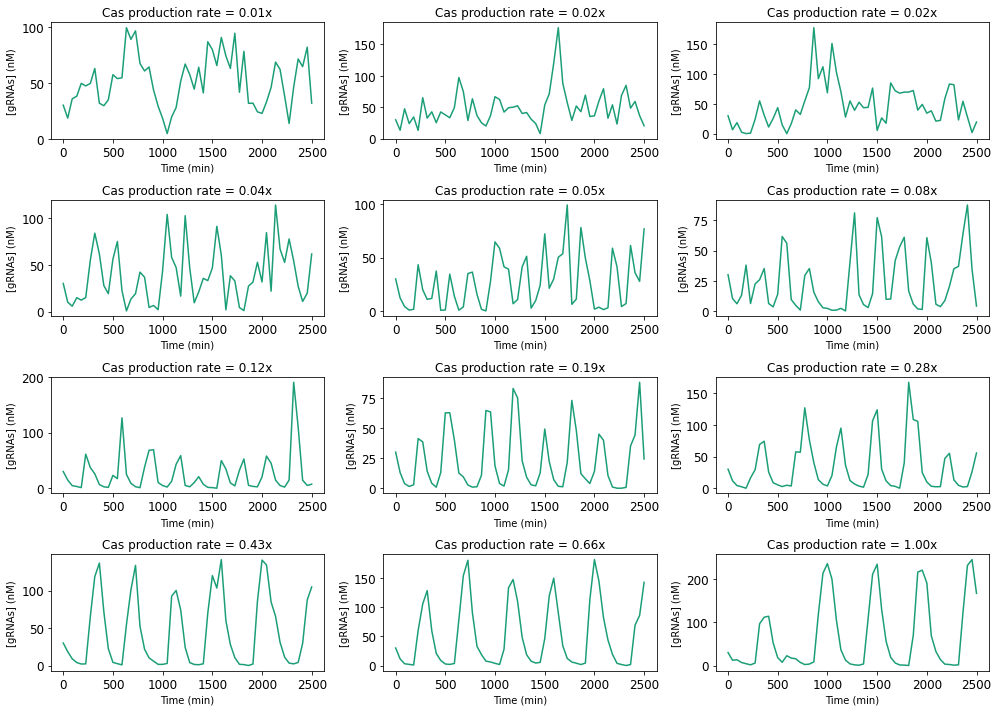

In [27]:
initial_conditions = {
    "DNA1": 5,
    "DNA2": 5,
    "DNA3": 5,
    "dCas": 43,
    "g1": 30
}
seed = 42335
np.random.seed(seed)
bs.random.py_seed_random(seed)
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

plt.figure(figsize = (14,10))

# Plasmid loss is a concern for simulations with no selection and small copy numbers like this; 
# we'll need to detect when there's loss of plasmid. Here's a helper function for that.
def lost_plasmid(model, results, end_t):
    s2idx = model.get_species2index()
    all_states = [cs for state_list in results for cs in state_list if cs.py_get_time() < end_t]
    end_time = max([cs.py_get_time() for cs in all_states])
    end_state = [cs for cs in all_states if cs.py_get_time() == end_time][0]
    for i in range(1, 4):
        dna_idxs = [s2idx[name] for name in s2idx if f"DNA{i}" in name]
        if sum([end_state.py_get_state()[idx] for idx in dna_idxs]) == 0:
            return True
    return False

for i, cas_rate in enumerate(np.geomspace(.01, 1, 12)):
    temp_params = copy.deepcopy(cas_params)
    temp_params['k_dCas_prod_rate'] *= cas_rate

    start_time = datetime.now()
    temp_paulsson_model = make_CRISPRlator_dummy(temp_params, initial_conditions, n_nodes = 3, lineage = True)

    # Simulate until you don't get accidental plasmid loss
    while True:
        temp_paulsson_results = simulate_with_caching(None,
                                              initial_cell_states = 1, 
                                              timepoints = temp_ts,
                                              sample_times = sample_times,
                                              population_cap = 1,
                                              Model = temp_paulsson_model, debug = False)
        if not lost_plasmid(temp_paulsson_model, temp_paulsson_results, end_t = 60*2500):
            break
        else:
            print("Lost a plasmid, repeating simultion")
            
    end_time = datetime.now()
    print("execution time: " + str(end_time - start_time))

    plt.subplot(4, 3, i+1)

    all_states = [cs for state_list in temp_paulsson_results for cs in state_list if cs.py_get_time()/60 < 2500]
    plotting_ts = [cs.py_get_time()/60 for cs in all_states]

    i = 1
    prev_i = 3
    gRNA_idx = temp_paulsson_model.get_species2index()[f"g{i}"]
    dCas_idx = temp_paulsson_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = temp_paulsson_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = temp_paulsson_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = good_colors[3][i-1])#, s = 9)

    plt.xlabel("Time (min)")
    plt.ylabel("[gRNAs] (nM)")
    plt.title(f"Cas production rate = {cas_rate:.2f}x")
plt.tight_layout()
plt.savefig(os.path.join('results', 'tuned_down_cas_CRISPRlator_low_copy.pdf'))
plt.show()

Those simulations with very little dCas9 look pretty similar to the Paulsson paper's data, and the ones with slightly more cas production look similar to the Cas12 oscillators.  

Can we get a similar level of matching for the Schaerli data? The big difference there is the timescale of oscillation -- but estimating from their supplemental movie, their cells have division times more like 50 minutes than like 30 (~4-5 frames per division, each frame is 10 minutes). If we simulate again with that dilution rate, we get:

execution time: 0:00:00.793795


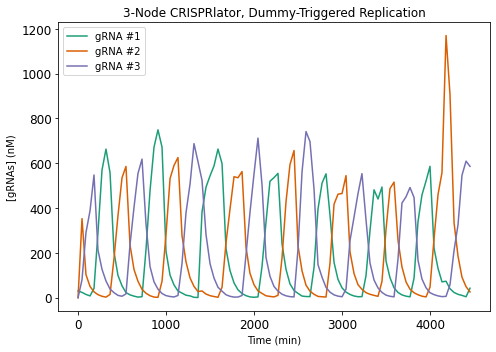

In [28]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "dCas": 43,
    "g1": 30
}
temp_params = copy.deepcopy(cas_params)
temp_params['k_dilution_rate'] = math.log(2) / (50 * 60)
temp_params['k_gamma'] = temp_params['k_dilution_rate']

seed = 42334
np.random.seed(42334)
bs.random.py_seed_random(42334)

start_time = datetime.now()
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

schaerli_model = make_CRISPRlator_dummy(temp_params, initial_conditions, n_nodes = 3, lineage = True)

schaerli_results = simulate_with_caching(None,
                                      initial_cell_states = 1, 
                                      timepoints = temp_ts,
                                      sample_times = sample_times,
                                      population_cap = 1,
                                      Model = schaerli_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

draw_schaerli_data(schaerli_results, schaerli_model)

Still way too fast. This circuit was made on a ColA backbone, which should have a copy number between 20 and 40, so this simulation's copy number should be correct. What if we fiddle with cas concentration like we did for Paulsson's paper?

execution time: 0:00:01.674795
execution time: 0:00:01.468212
execution time: 0:00:01.398305
execution time: 0:00:01.084010
execution time: 0:00:00.871190
execution time: 0:00:00.738976
execution time: 0:00:00.660385
execution time: 0:00:00.674456
execution time: 0:00:00.589733
execution time: 0:00:00.596715
execution time: 0:00:00.681839
execution time: 0:00:00.620703


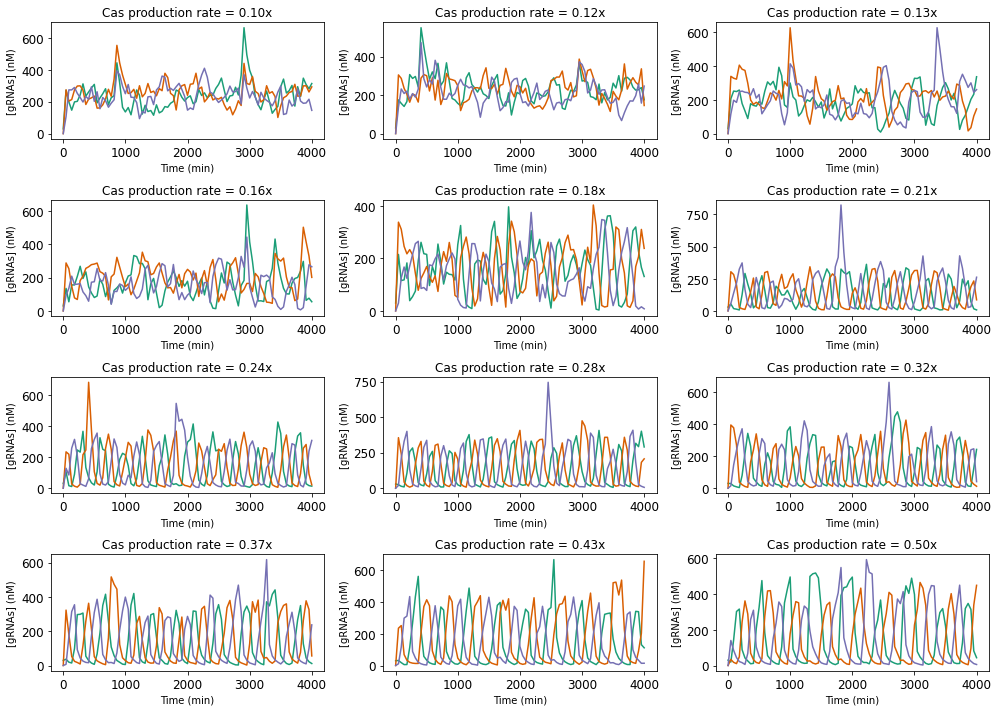

In [29]:
initial_conditions = {
    "DNA1": 30,
    "DNA2": 30,
    "DNA3": 30,
    "dCas": 43,
    "g1": 30
}
seed = 42335
np.random.seed(seed)
bs.random.py_seed_random(seed)
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, 4000)
sample_times = np.linspace(0, t_max, 100) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

plt.figure(figsize = (14,10))

for i, cas_rate in enumerate(np.geomspace(.1, .5, 12)):#np.geomspace(.01, 1, 12)):
    temp_params = copy.deepcopy(cas_params)
    temp_params['k_dCas_prod_rate'] *= cas_rate
    temp_params['k_dilution_rate'] = math.log(2) / (50 * 60)
    temp_params['k_gamma'] = temp_params['k_dilution_rate']

    start_time = datetime.now()
    temp_schaerli_model = make_CRISPRlator_dummy(temp_params, initial_conditions, n_nodes = 3, lineage = True)

    # Simulate until you don't get accidental plasmid loss
    while True:
        temp_schaerli_results = simulate_with_caching(None,#f"tuned_cas_{i}",
                                              initial_cell_states = 1, 
                                              timepoints = temp_ts,
                                              sample_times = sample_times,
                                              population_cap = 1,
                                              Model = temp_schaerli_model, debug = False)
        if not lost_plasmid(temp_schaerli_model, temp_schaerli_results, end_t = 60*4000):
            break
        else:
            print("Lost a plasmid, repeating simultion")
            
    end_time = datetime.now()
    print("execution time: " + str(end_time - start_time))

    plt.subplot(4, 3, i+1)

    all_states = [cs for state_list in temp_schaerli_results for cs in state_list if cs.py_get_time()/60 < 4000]
    plotting_ts = [cs.py_get_time()/60 for cs in all_states]

    for k in range(1, 4):
        prev_k = (k-2)%3 + 1
        gRNA_idx = temp_schaerli_model.get_species2index()[f"g{k}"]
        dCas_idx = temp_schaerli_model.get_species2index()[f"dCas_g{k}"]
        dna_idx = temp_schaerli_model.get_species2index()[f"DNA{prev_k}_g{k}"]
        bare_dna_idx = temp_schaerli_model.get_species2index()[f"DNA{prev_k}"]

        bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
        dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
        dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
        bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
        total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
        total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

        plt.plot(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                    color = good_colors[3][k-1])#, s = 9)

    plt.xlabel("Time (min)")
    plt.ylabel("[gRNAs] (nM)")
    plt.title(f"Cas production rate = {cas_rate:.2f}x")
plt.tight_layout()
plt.savefig(os.path.join('results', 'tuned_down_cas_CRISPRlator.pdf'))
plt.show()

Nope, we do *not* see oscillations of the kind found in Schaerli's paper.

# Cross-Cell Synchronization

If we let an oscillating cell grow and divide for a while, will its descendents stay synchronized? Or will their oscillations drift apart quickly? We can ask this question most easily with dummy-triggered replicating DNA.

In [30]:
initial_conditions = {
    "DNA1": 40,
    "DNA2": 40,
    "DNA3": 40,
    "DNA4": 40,
    "DNA5": 40,
    "dCas": 43,
    "g1": 30
}

seed = 42334
np.random.seed(seed)
bs.random.py_seed_random(seed)

start_time = datetime.now()
n_generations = 150
t_max = n_generations*30*60
temp_ts = np.linspace(0, t_max, n_generations*10)
sample_times = np.linspace(0, t_max, 300) #<- Lineages doesn't like having too few
                                                # sample times, don't use just one or two.

dummy_synch_model = make_CRISPRlator_dummy(cas_params, initial_conditions, 
                                           lineage = True, selection = False)

#     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
#     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
dummy_synch_results = simulate_with_caching('CRISPR_synch_dummy.pkl',
                                      initial_cell_states = 1, 
                                      timepoints = temp_ts,
                                      sample_times = sample_times,
                                      population_cap = 64,
                                      Model = dummy_synch_model, debug = False)                                                                                  
end_time = datetime.now()
print("execution time: " + str(end_time - start_time))

Using cached results from file cached_results/CRISPR_synch_dummy.pkl.
execution time: 0:00:00.108834


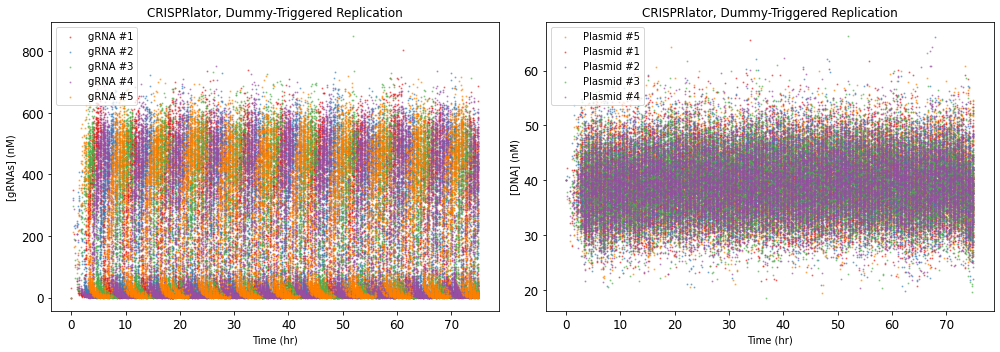

In [31]:
plt.figure(figsize = (14,5))

all_states = [cs for state_list in dummy_synch_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = dummy_synch_model.get_species2index()[f"g{i}"]
    dCas_idx = dummy_synch_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = dummy_synch_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = dummy_synch_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    plt.subplot(121)
    plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}", 
                color = color_list[i-1], s = 1, alpha = .5)
    plt.subplot(122)
    plt.scatter(plotting_ts, total_dna, label = f"Plasmid #{prev_i}",
                color = color_list[prev_i-1], s = 1, alpha = .5)
    
plt.subplot(121)
plt.xlabel("Time (hr)")
plt.ylabel("[gRNAs] (nM)")
plt.title(f"CRISPRlator, Dummy-Triggered Replication")
plt.legend()

plt.subplot(122)
plt.xlabel("Time (hr)")
plt.ylabel("[DNA] (nM)")
plt.title("CRISPRlator, Dummy-Triggered Replication")
plt.legend()
plt.tight_layout()
plt.show()

Shown another way:

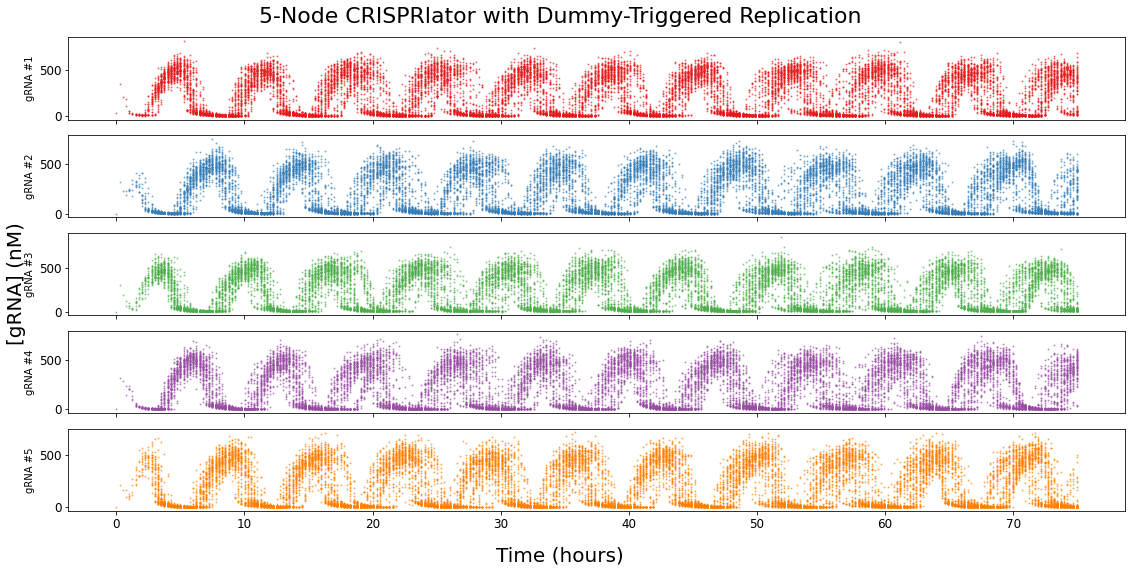

In [32]:
fig = plt.figure(figsize=(16,8))

all_states = [cs for state_list in dummy_synch_results for cs in state_list]
plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

for i in range(1, 6):
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = dummy_synch_model.get_species2index()[f"g{i}"]
    dCas_idx = dummy_synch_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = dummy_synch_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = dummy_synch_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    curr_ax = plt.subplot(5, 1, i)
    plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}",
                color = color_list[i-1], s = 1, alpha = .5)
    plt.ylabel(f"gRNA #{i}", x=0.08)
    if i<5:
        plt.setp(curr_ax.get_xticklabels(), visible=False)

fig.supylabel("[gRNA] (nM)", fontsize = 20)
fig.supxlabel("Time (hours)", fontsize = 20)
fig.suptitle("5-Node CRISPRlator with Dummy-Triggered Replication", fontsize = 22)
plt.tight_layout()
plt.savefig(os.path.join('results', 'synchronization.pdf'))
plt.show()

# Stochastic breakdown of the CRISPRlator

We've seen that the CRISPRlator still functions on a medium-copy plasmid. How low can we push that copy number? To answer this, we'll again use the dummy-triggered replication model, since it's much faster to simulate. gRNA production levels will be rescaled so that each cell still produces the same total amount of gRNA.

Because we'll be looking at cells with very low copy number, we're going to have to add a selection mechanism. As in the basic models (see `model_comparison_and_fitting.ipynb`), the mechanism is simply that cells with no plasmid don't grow, where "plasmid" is defined here as a species with "DNA" in its name.

Using cached results from file cached_results/CRISPR_copy_num_1.pkl.
execution time for copy # 1: 0:00:00.118455


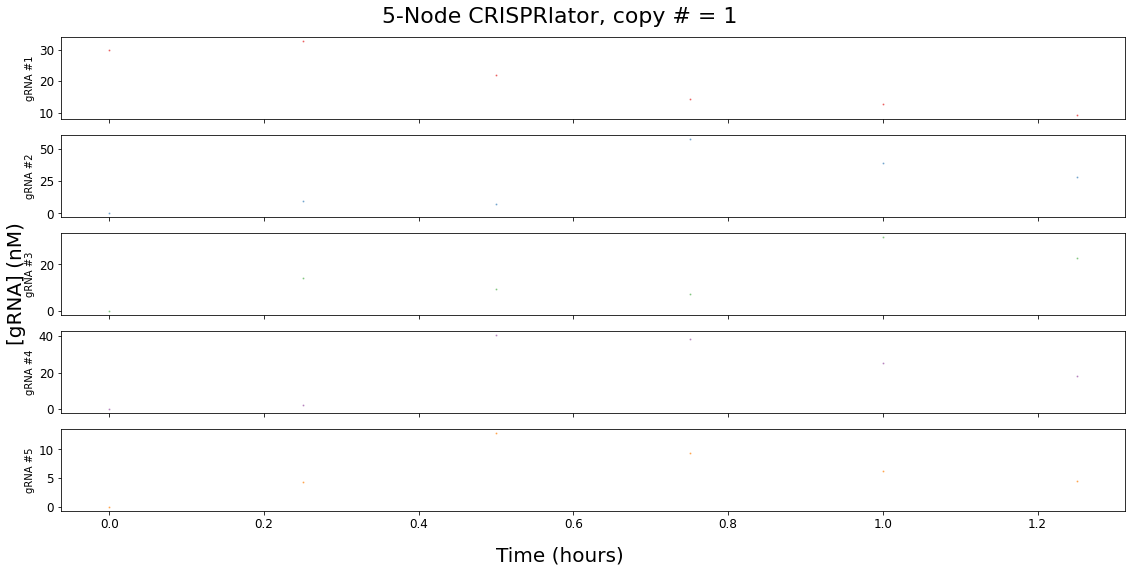

Using cached results from file cached_results/CRISPR_copy_num_2.pkl.
execution time for copy # 2: 0:00:00.266488


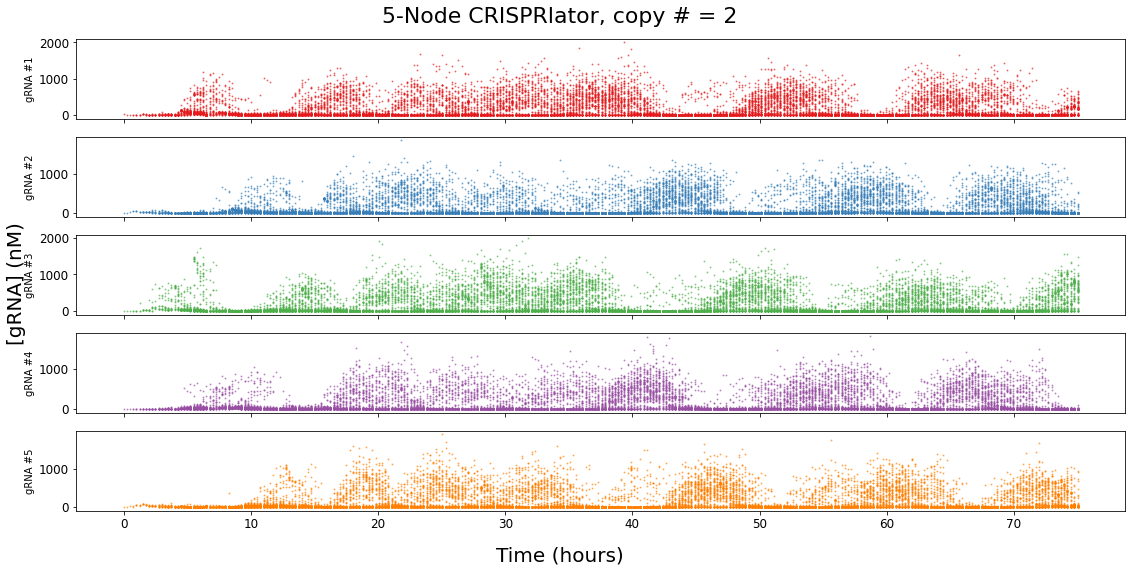

Using cached results from file cached_results/CRISPR_copy_num_3.pkl.
execution time for copy # 3: 0:00:00.110252


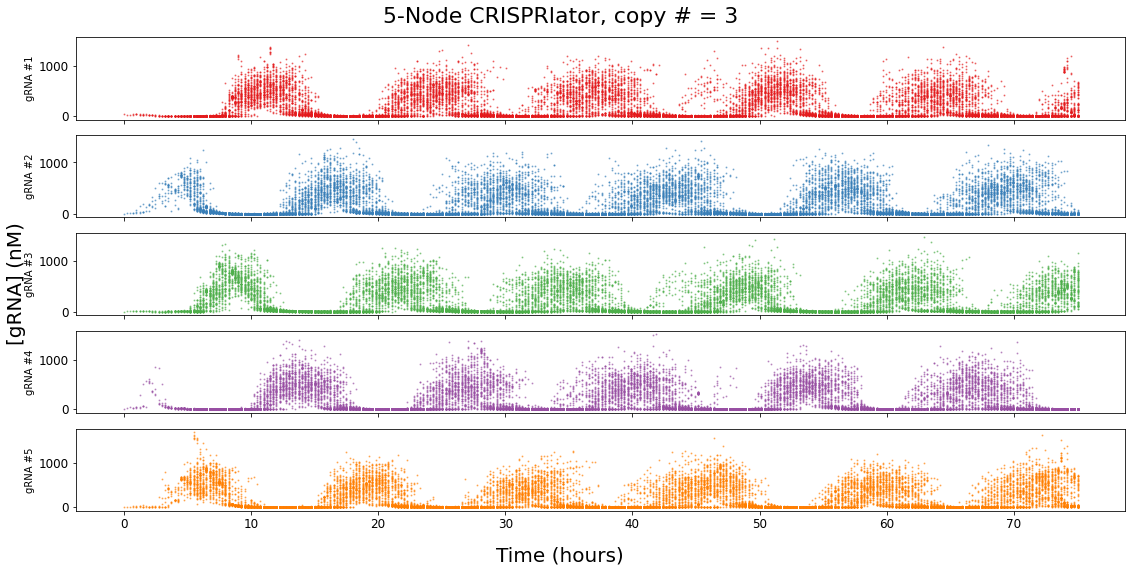

Using cached results from file cached_results/CRISPR_copy_num_4.pkl.
execution time for copy # 4: 0:00:00.481528


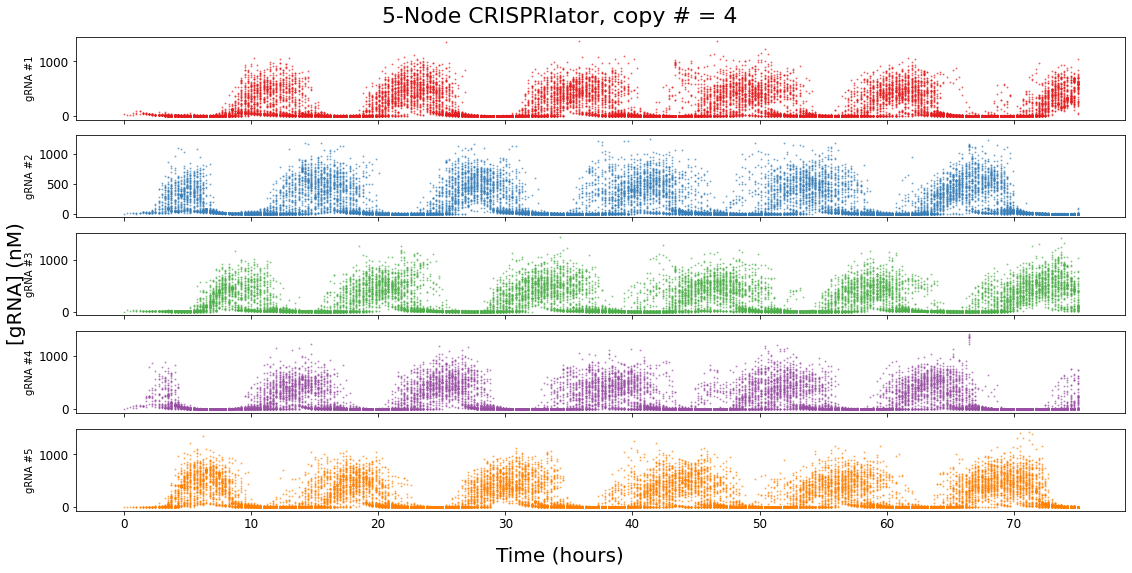

Using cached results from file cached_results/CRISPR_copy_num_5.pkl.
execution time for copy # 5: 0:00:00.224489


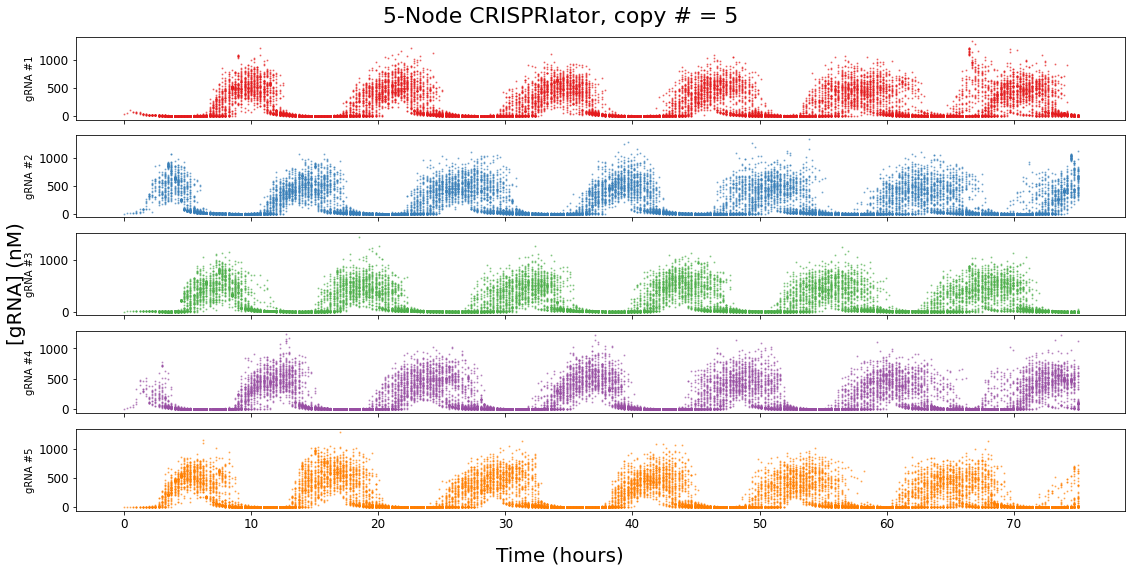

Using cached results from file cached_results/CRISPR_copy_num_6.pkl.
execution time for copy # 6: 0:00:00.413081


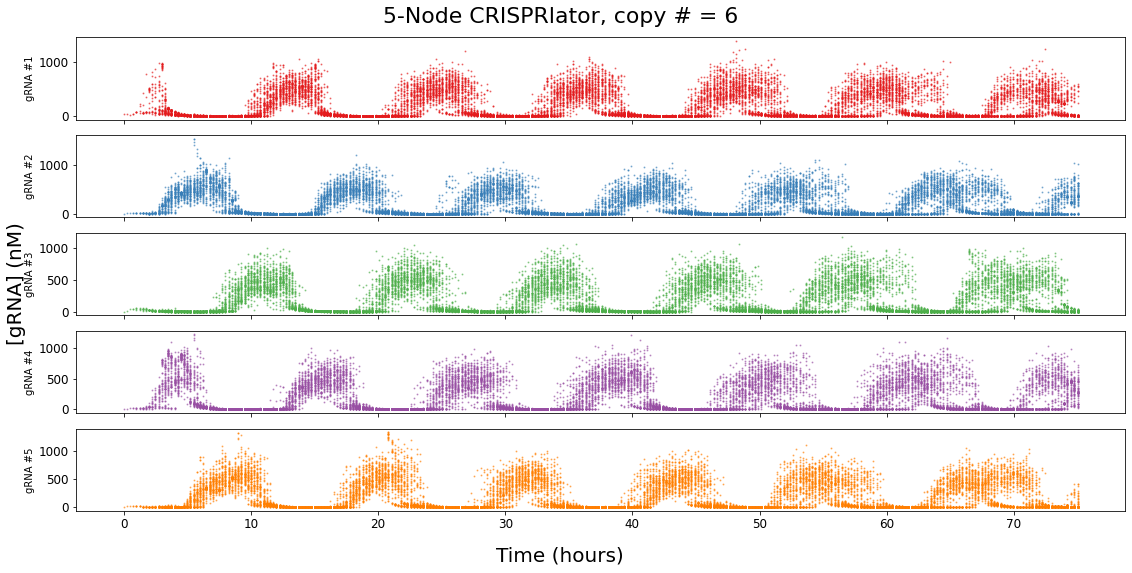

Using cached results from file cached_results/CRISPR_copy_num_7.pkl.
execution time for copy # 7: 0:00:00.098630


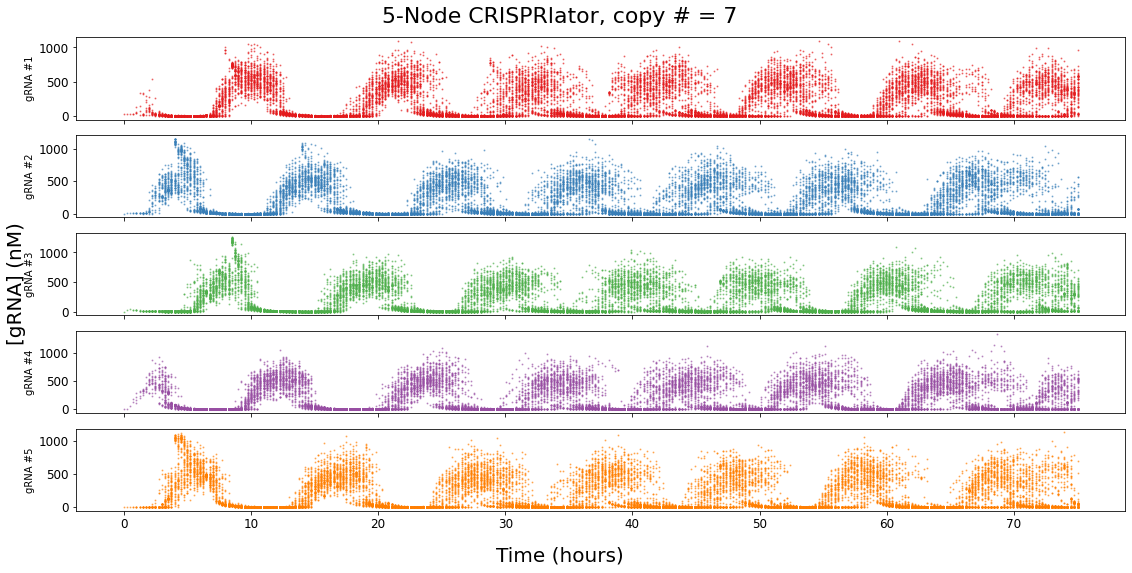

Using cached results from file cached_results/CRISPR_copy_num_8.pkl.
execution time for copy # 8: 0:00:00.310684


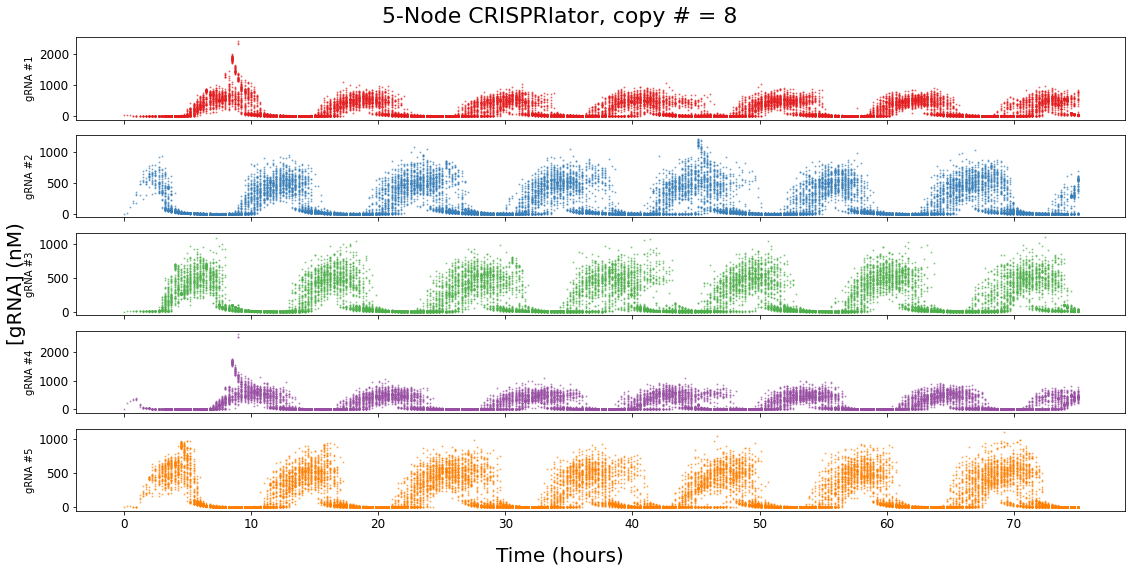

Using cached results from file cached_results/CRISPR_copy_num_9.pkl.
execution time for copy # 9: 0:00:00.087353


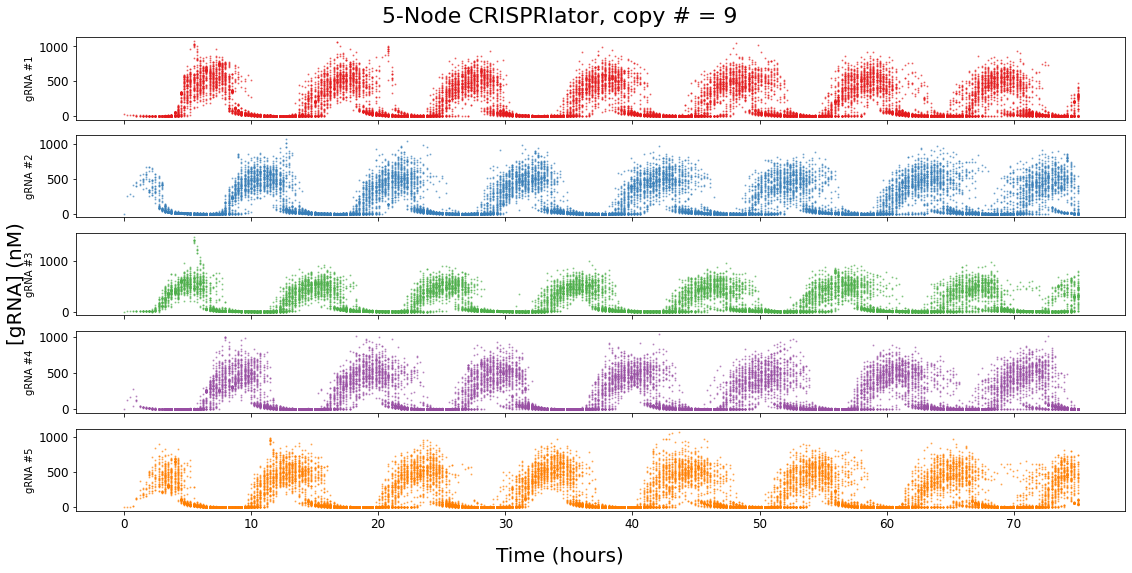

Using cached results from file cached_results/CRISPR_copy_num_10.pkl.
execution time for copy # 10: 0:00:00.083385


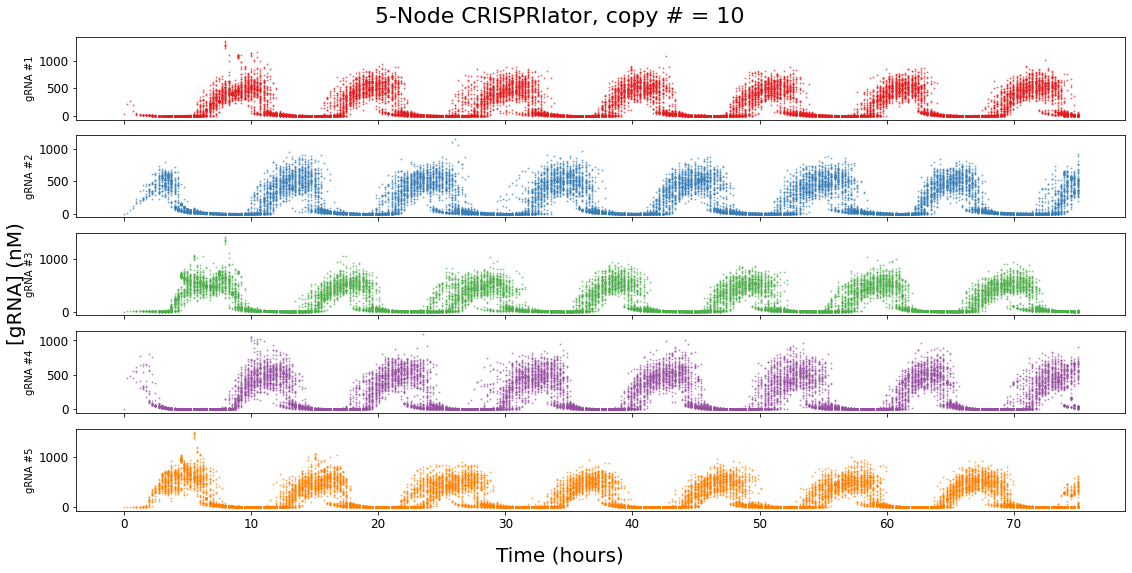

Using cached results from file cached_results/CRISPR_copy_num_15.pkl.
execution time for copy # 15: 0:00:00.236360


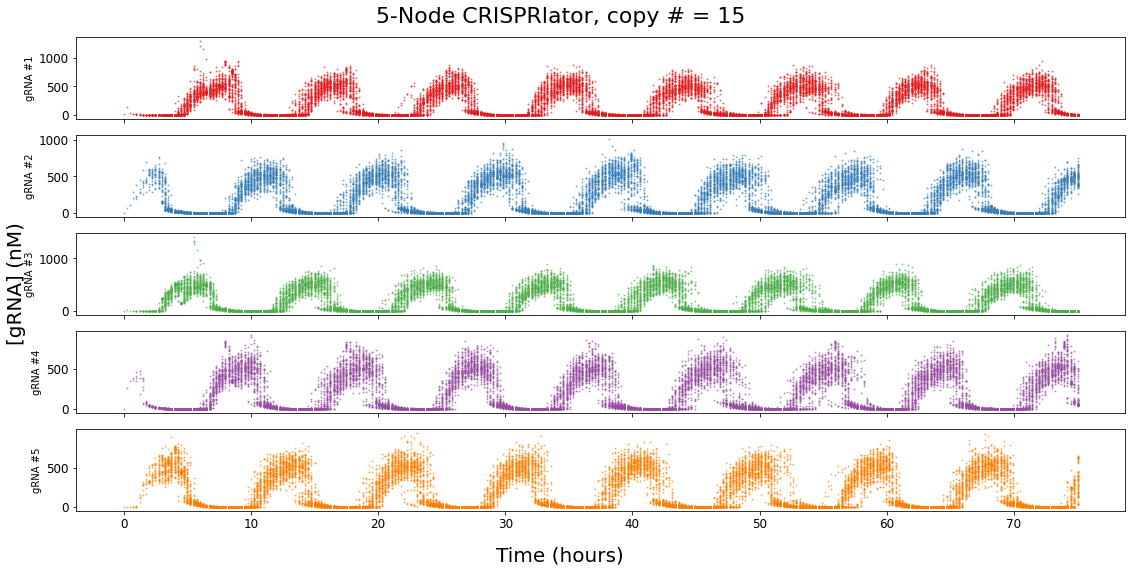

Using cached results from file cached_results/CRISPR_copy_num_20.pkl.
execution time for copy # 20: 0:00:00.084558


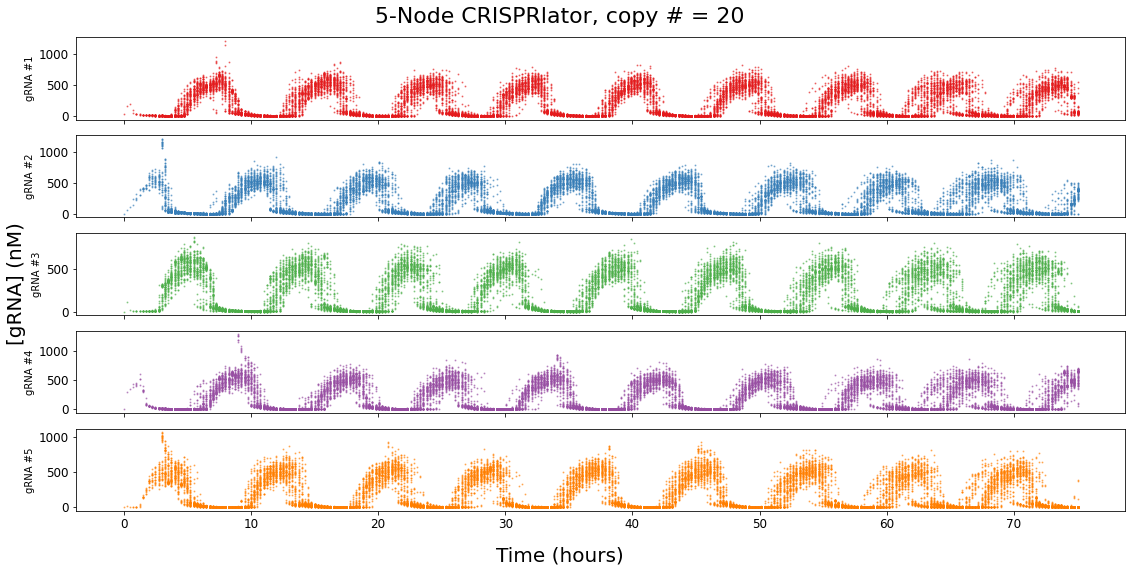

Using cached results from file cached_results/CRISPR_copy_num_25.pkl.
execution time for copy # 25: 0:00:00.092667


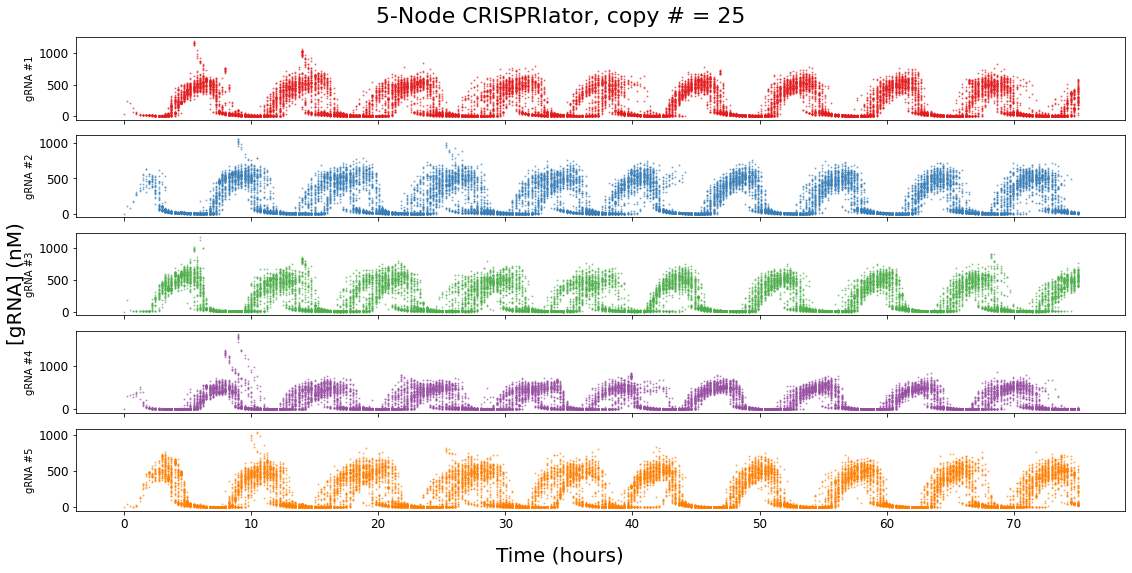

Using cached results from file cached_results/CRISPR_copy_num_30.pkl.
execution time for copy # 30: 0:00:00.291299


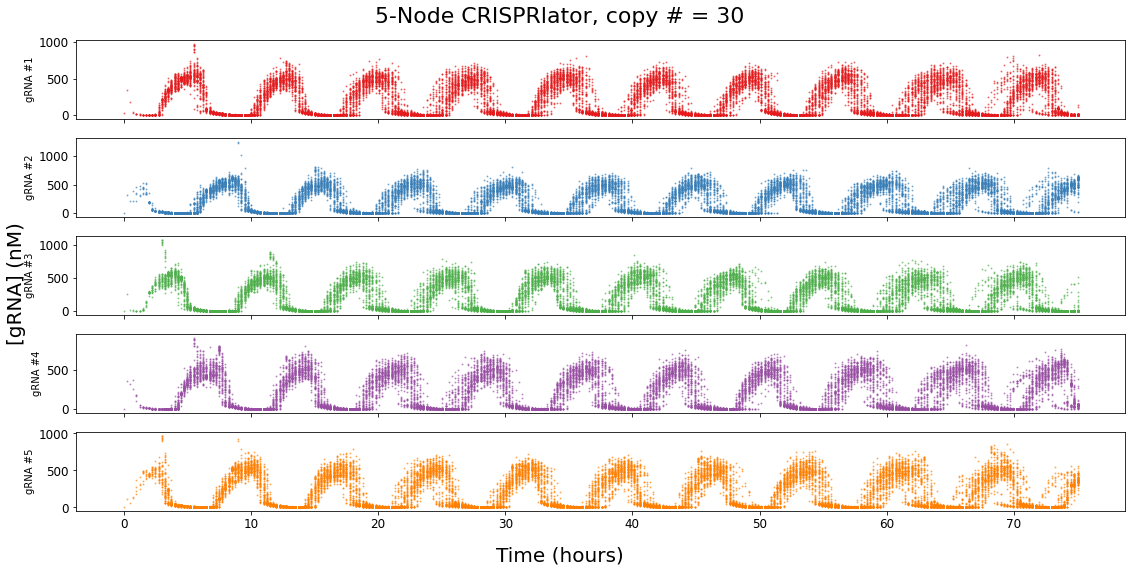

Using cached results from file cached_results/CRISPR_copy_num_35.pkl.
execution time for copy # 35: 0:00:00.079720


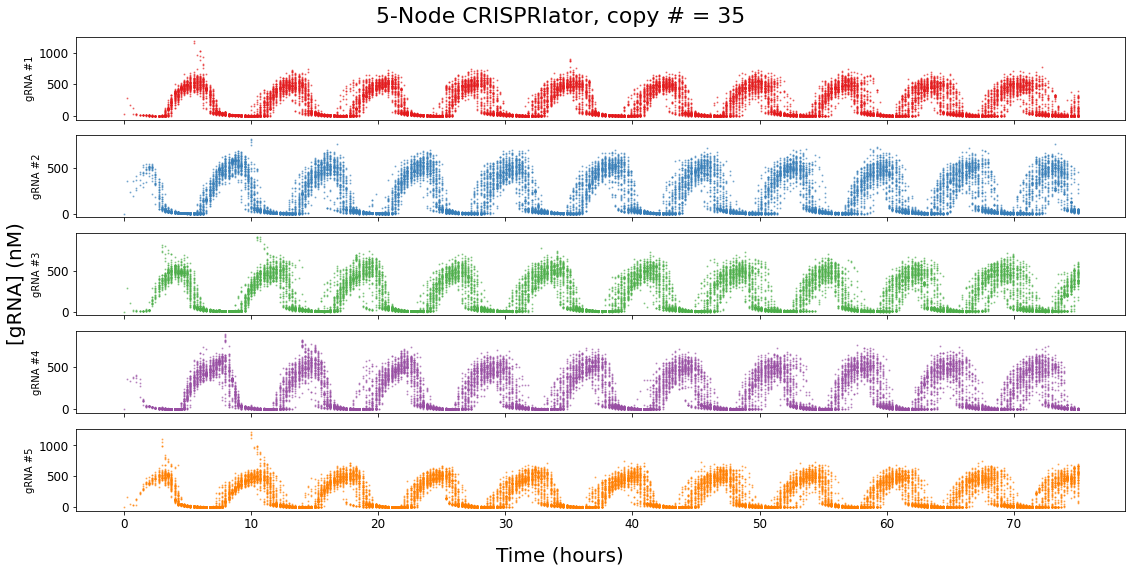

Using cached results from file cached_results/CRISPR_copy_num_40.pkl.
execution time for copy # 40: 0:00:00.103392


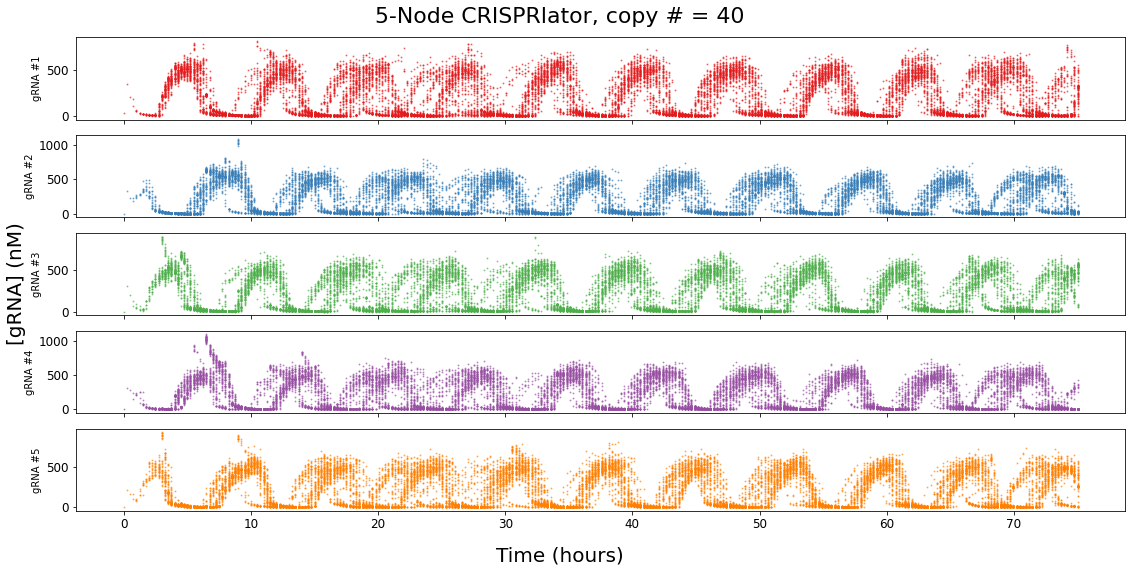

In [33]:
variable_copy_results = dict()
for copy_number in list(range(1, 10)) + list(range(10, 41, 5)):
    initial_conditions = {
        "DNA1": copy_number,
        "DNA2": copy_number,
        "DNA3": copy_number,
        "DNA4": copy_number,
        "DNA5": copy_number,
        "dCas": 43,
        "g1": 30
    }
    
    variable_copy_params = copy.deepcopy(cas_params)
    variable_copy_params['k_gRNA_prod_rate'] *= 40/copy_number

    seed = 42334
    np.random.seed(42334)
    bs.random.py_seed_random(42334)

    start_time = datetime.now()
    n_generations = 150
    t_max = n_generations*30*60
    temp_ts = np.linspace(0, t_max, n_generations*10)
    sample_times = np.linspace(0, t_max, 300) #<- Lineages doesn't like having too few
                                                    # sample times, don't use just one or two.

    temp_model = make_CRISPRlator_dummy(variable_copy_params, initial_conditions, lineage = True,
                                        selection = True, selection_type = "die")    

    #     all_distributions[model_name] = bs_lineage.py_SimulateCellLineage(temp_ts, [], initial_cell_count = 1, Model = model)
    #     [bs.simulator.py_simulate_model(temp_ts, model, stochastic = True) for i in range(2)]
    variable_copy_results[copy_number] = simulate_with_caching(f'CRISPR_copy_num_{copy_number}.pkl',
                                          initial_cell_states = 1, 
                                          timepoints = temp_ts,
                                          sample_times = sample_times,
                                          population_cap = 64,
                                          Model = temp_model, debug = False)                                                                                  
    end_time = datetime.now()
    print(f"execution time for copy # {copy_number}: " + str(end_time - start_time))
    temp_results = variable_copy_results[copy_number]
    
    fig = plt.figure(figsize=(16,8))

    all_states = [cs for state_list in temp_results for cs in state_list]
    plotting_ts = np.array([cs.py_get_time()/3600 for cs in all_states])

    for i in range(1, 6):
        prev_i = prev_i = (i-2)%5 + 1
        gRNA_idx = temp_model.get_species2index()[f"g{i}"]
        dCas_idx = temp_model.get_species2index()[f"dCas_g{i}"]
        dna_idx = temp_model.get_species2index()[f"DNA{prev_i}_g{i}"]
        bare_dna_idx = temp_model.get_species2index()[f"DNA{prev_i}"]

        bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
        dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
        dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
#         bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
        total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]

        curr_ax = plt.subplot(5, 1, i)
        plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}",
                    color = color_list[i-1], s = 1, alpha = .5)
        plt.ylabel(f"gRNA #{i}", x=0.08)
        if i<5:
            plt.setp(curr_ax.get_xticklabels(), visible=False)
        
#         no_plasmid_idxs = np.where(total_dna == 0)[0]
#         if len(no_plasmid_idxs) > 0:
#             plt.axvline(plotting_ts[no_plasmid_idxs.min()], color = color_list[i-1])

    fig.supylabel("[gRNA] (nM)", fontsize = 20)
    fig.supxlabel("Time (hours)", fontsize = 20)
    fig.suptitle(f"5-Node CRISPRlator, copy # = {copy_number}", fontsize = 22)
    plt.tight_layout()
    plt.savefig(os.path.join('results', f'CRISPR_copy_num_{copy_number}_results.png'), dpi = 300)
    plt.show()

Just plotting the first guide for better visualization:

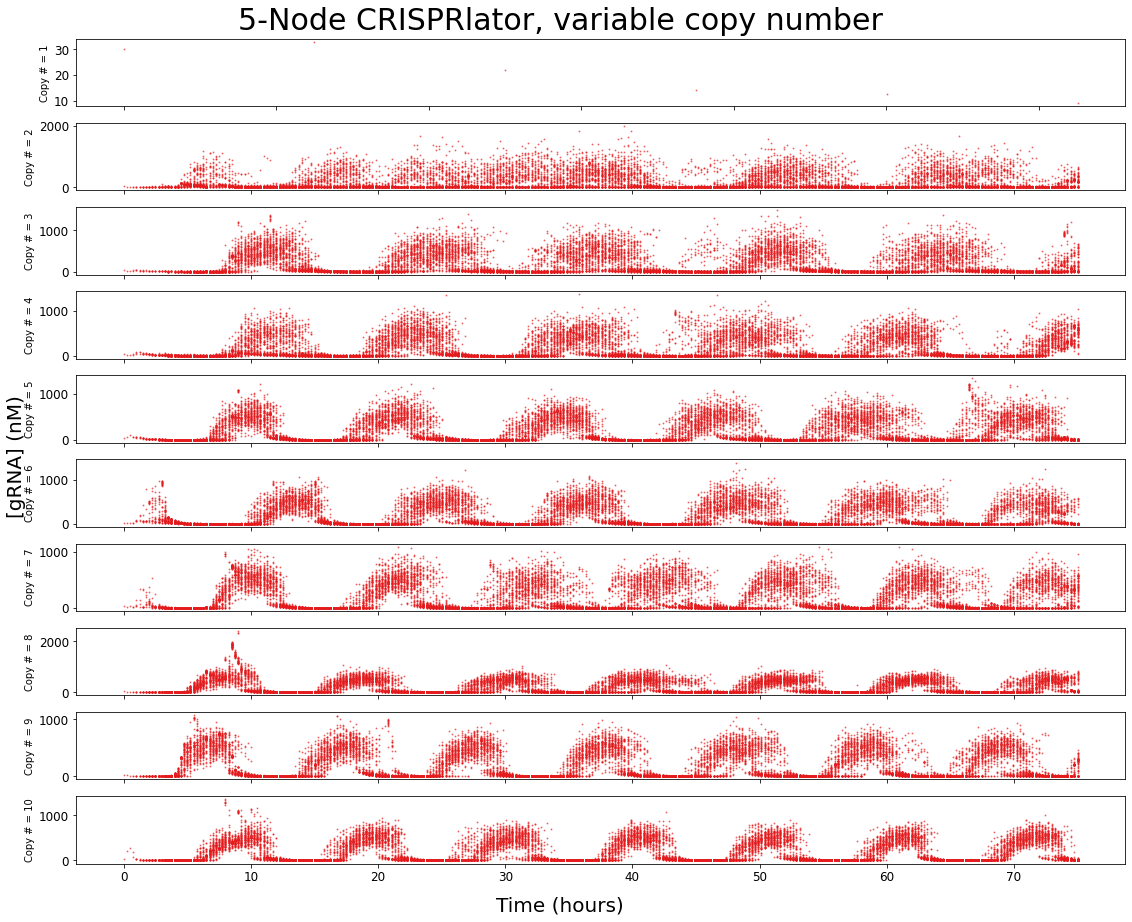

In [35]:
cutoff = 10
n_copy_nums = len(variable_copy_results)
f = plt.figure(figsize = (16,13))

for j, copy_number in enumerate(variable_copy_results.keys()):
    if copy_number > cutoff:
        continue
    temp_results = variable_copy_results[copy_number]
    all_states = [cs for state_list in temp_results for cs in state_list]
    plotting_ts = [cs.py_get_time()/3600 for cs in all_states]

    i = 1
    prev_i = prev_i = (i-2)%5 + 1
    gRNA_idx = temp_model.get_species2index()[f"g{i}"]
    dCas_idx = temp_model.get_species2index()[f"dCas_g{i}"]
    dna_idx = temp_model.get_species2index()[f"DNA{prev_i}_g{i}"]
    bare_dna_idx = temp_model.get_species2index()[f"DNA{prev_i}"]

    bare_gRNA = [cs.py_get_state()[gRNA_idx]/cs.py_get_volume() for cs in all_states]
    dCas_gRNA = [cs.py_get_state()[dCas_idx]/cs.py_get_volume() for cs in all_states]
    dna_gRNA = [cs.py_get_state()[dna_idx]/cs.py_get_volume() for cs in all_states]
    bare_dna = [cs.py_get_state()[bare_dna_idx]/cs.py_get_volume() for cs in all_states]
    total_gRNA = [bare_gRNA[j] + dCas_gRNA[j] + dna_gRNA[j] for j in range(len(all_states))]
    total_dna = [bare_dna[j] + dna_gRNA[j] for j in range(len(all_states))]

    curr_ax = plt.subplot(cutoff, 1, j+1)
    plt.scatter(plotting_ts, total_gRNA, label = f"gRNA #{i}",
                color = color_list[i-1], s = 1, alpha = .5)
    plt.ylabel(f"Copy # = {copy_number}")
    if copy_number != cutoff:
        plt.setp(curr_ax.get_xticklabels(), visible=False)

f.suptitle(f"5-Node CRISPRlator, variable copy number", fontsize = 30)
f.supylabel("[gRNA] (nM)", fontsize = 20)
f.supxlabel("Time (hours)", fontsize = 20)
f.tight_layout()
plt.savefig(os.path.join('results', 'CRISPR_cross_copy_num.png'), dpi = 300)
plt.show()